# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [55]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math
import heapq
import time
import random
import itertools
import matplotlib.cm as cm
from scipy.ndimage import binary_dilation
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


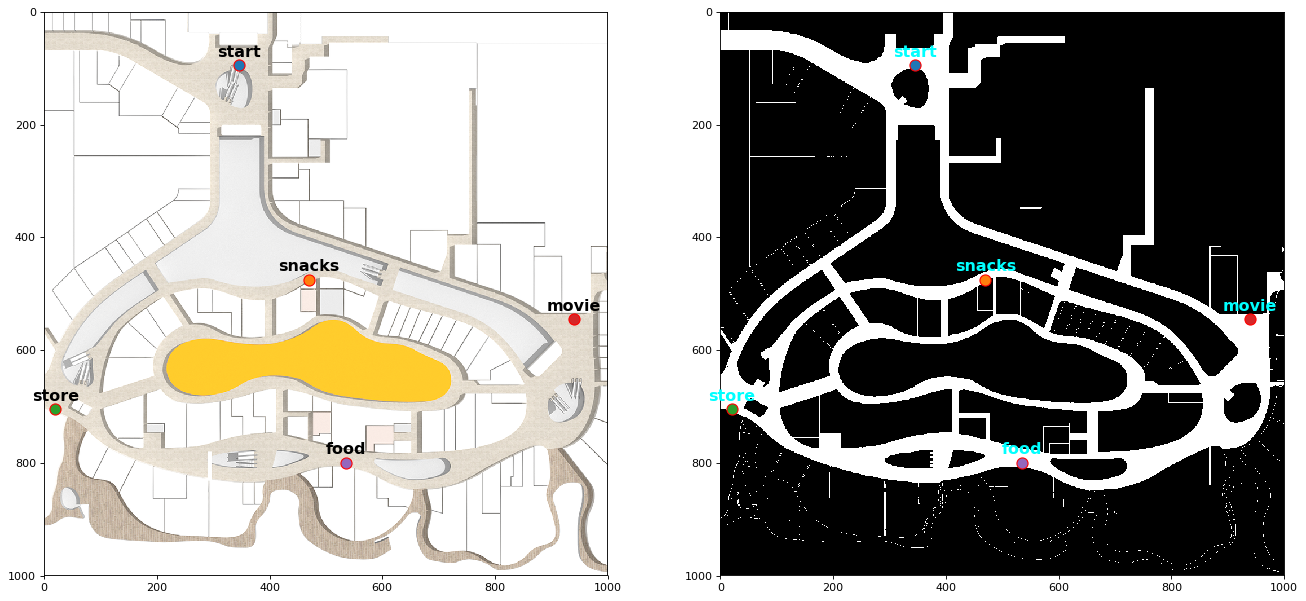

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [56]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }
coord_to_name = {tuple(value): key for key, value in locations.items()}

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', color=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [57]:
class AStarPlanner:
    def __init__(self, map_array, resolution=0.2, footprint_radius=0.3, heuristic_func=None):
        """
        Initializes the A* planner.

        Args:
            map_array (numpy.ndarray): Grayscale map, where 255 indicates free and 0 indicates obstacles.
            resolution (float): The size of each grid cell in meters.
            footprint_radius (float): The required safe radius (in meters) for the human/robot footprint.
            heuristic_func (callable): A heuristic function accepting two nodes (p1, p2).
        """
        self.original_map = map_array
        self.resolution = resolution
        self.footprint_radius = footprint_radius
        # Calculate the inflation radius in grid cells.
        self.inflation_radius = int(np.ceil(footprint_radius / resolution))
        # Preprocess the map by inflating obstacles.
        self.map = self.preprocess_map(map_array)
        self.heuristic = heuristic_func
        self.height, self.width = self.map.shape

    def preprocess_map(self, map_array):
        """
        Preprocesses the map by inflating obstacles to ensure that the planned path maintains a safe distance.
        Uses SciPy's binary_dilation to perform the inflation.

        Args:
            map_array (numpy.ndarray): Grayscale map (255 indicates free, 0 indicates obstacles).

        Returns:
            numpy.ndarray: The inflated map, with obstacles set to 0 and free space to 255.
        """
        # Convert obstacles (0) to a binary map: obstacles become 1, free becomes 0.
        binary_map = (map_array == 0).astype(np.uint8)
        # Define the dilation kernel with size (2 * inflation_radius + 1) x (2 * inflation_radius + 1).
        struct = np.ones((self.inflation_radius + 1, self.inflation_radius + 1), dtype=np.uint8)
        # Dilate obstacles (the expanded obstacle region will be True).
        expanded_grid = binary_dilation(binary_map, structure=struct).astype(int)
        # Convert the binary map back to the original format: obstacles become 0, free becomes 255.
        inflated_map = 255 - expanded_grid * 255
        return inflated_map

    def get_neighbors(self, node):
        """
        Returns the 8-connected neighbors of the given node.
        The cost for cardinal moves (up, down, left, right) is 0.2,
        and for diagonal moves is 0.282.

        Args:
            node (tuple): The current node as (row, col).

        Returns:
            list: A list of tuples of the form ((neighbor_row, neighbor_col), move_cost).
        """
        (r, c) = node
        rows, cols = self.map.shape
        directions = [
            (-1, 0), (1, 0), (0, -1), (0, 1),      # Cardinal directions
            (-1, -1), (-1, 1), (1, -1), (1, 1)       # Diagonal directions
        ]
        neighbors = []
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            # Check boundary conditions.
            if 0 <= nr < rows and 0 <= nc < cols:
                # Check if the cell is free (255).
                if self.map[nr, nc] == 255:
                    # If both dr and dc are non-zero, it's a diagonal move.
                    if dr != 0 and dc != 0:
                        move_cost = 0.282
                    else:
                        move_cost = 0.2
                    neighbors.append(((nr, nc), move_cost))
        return neighbors

    def plan(self, start, goal):
        """
        Executes A* path planning from the start node to the goal node.

        Args:
            start (tuple): The start node as (row, col).
            goal (tuple): The goal node as (row, col).

        Returns:
            tuple: A tuple containing:
                - path (list): The planned path as a list of nodes (each node is a tuple (row, col)).
                - cost (float): The total travel cost in meters.
                - visited (set): A set of all visited cells during the search.
        """
        open_list = []
        # Push the start node into the priority queue.
        # Each element is a tuple: (f = g + h, current cost g, current node, parent node).
        heapq.heappush(open_list, (self.heuristic(start, goal), 0, start, None))
        came_from = {}  # Dictionary to record each node's parent for path reconstruction.
        cost_so_far = {start: 0}
        visited = set()
        
        while open_list:
            f_current, g_current, current, parent = heapq.heappop(open_list)
            # Skip if the node has already been visited.
            if current in visited:
                continue
            visited.add(current)
            came_from[current] = parent
            
            # If the goal is reached, reconstruct the path.
            if current == goal:
                # Print the success message using location names from the global mapping.
                print(f"Path found between {coord_to_name[start]} and {coord_to_name[goal]}.")
                path = []
                node = current
                while node in came_from:
                    path.append(node)
                    node = came_from.get(node)
                path.append(start)
                path.reverse()
                return path, cost_so_far[current], visited
            
            # Explore neighbors of the current node.
            for neighbor, move_cost in self.get_neighbors(current):
                if neighbor in visited:
                    continue
                new_g = g_current + move_cost
                if neighbor not in cost_so_far or new_g < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_g
                    h_val = self.heuristic(neighbor, goal)
                    f_val = new_g + h_val
                    heapq.heappush(open_list, (f_val, new_g, neighbor, current))
                    came_from[neighbor] = current
                        
        # If no path is found, return None.
        return None, float('inf'), visited

class BidirectionalAStarPlanner(AStarPlanner):
    """A bidirectional A* planner that inherits from AStarPlanner.
    
    The plan() method is overridden to perform simultaneous search from both start and goal.
    """
    def plan(self, start, goal):
        """
        Executes bidirectional A* search from start to goal.

        Args:
            start (tuple): Start node (row, col).
            goal (tuple): Goal node (row, col).

        Returns:
            tuple: (path, cost, visited) where
                path (list): The reconstructed path from start to goal (each node is (row, col)).
                cost (float): Total travel cost in meters.
                visited (set): All visited nodes during the search.
            If no path is found, returns (None, float('inf'), visited).
        """
        # Initialize open lists for forward and backward searches.
        open_start = []
        open_goal = []
        heapq.heappush(open_start, (self.heuristic(start, goal), 0, start, None))
        heapq.heappush(open_goal, (self.heuristic(goal, start), 0, goal, None))
        
        # Dictionaries for path reconstruction.
        came_from_start = {start: None}
        came_from_goal = {goal: None}
        cost_so_far_start = {start: 0}
        cost_so_far_goal = {goal: 0}
        
        visited_start = set()
        visited_goal = set()
        
        meeting_node = None
        best_cost = float('inf')
        
        # Main loop: alternate expanding from start and goal.
        while open_start and open_goal:
            # Expand one node from the start side.
            f_current, g_current, current, parent = heapq.heappop(open_start)
            if current in visited_start:
                pass  # Already processed.
            else:
                visited_start.add(current)
                came_from_start[current] = parent
                
                # Check if current is already visited by the backward search.
                if current in visited_goal:
                    total_cost = cost_so_far_start[current] + cost_so_far_goal[current]
                    if total_cost < best_cost:
                        best_cost = total_cost
                        meeting_node = current
                
                # Expand neighbors from forward side.
                for neighbor, move_cost in self.get_neighbors(current):
                    if neighbor in visited_start:
                        continue
                    new_g = g_current + move_cost
                    if neighbor not in cost_so_far_start or new_g < cost_so_far_start[neighbor]:
                        cost_so_far_start[neighbor] = new_g
                        h_val = self.heuristic(neighbor, goal)
                        f_val = new_g + h_val
                        heapq.heappush(open_start, (f_val, new_g, neighbor, current))
                        came_from_start[neighbor] = current
            
            # Expand one node from the goal side.
            f_current, g_current, current, parent = heapq.heappop(open_goal)
            if current in visited_goal:
                pass
            else:
                visited_goal.add(current)
                came_from_goal[current] = parent
                
                # Check if current is already visited by the forward search.
                if current in visited_start:
                    total_cost = cost_so_far_start[current] + cost_so_far_goal[current]
                    if total_cost < best_cost:
                        best_cost = total_cost
                        meeting_node = current
                
                # Expand neighbors from backward side.
                for neighbor, move_cost in self.get_neighbors(current):
                    if neighbor in visited_goal:
                        continue
                    new_g = g_current + move_cost
                    if neighbor not in cost_so_far_goal or new_g < cost_so_far_goal[neighbor]:
                        cost_so_far_goal[neighbor] = new_g
                        h_val = self.heuristic(neighbor, start)
                        f_val = new_g + h_val
                        heapq.heappush(open_goal, (f_val, new_g, neighbor, current))
                        came_from_goal[neighbor] = current
            
            # If a meeting node is found, break out of the loop.
            if meeting_node is not None:
                print(f"Path found between {coord_to_name[start]} and {coord_to_name[goal]}.")
                break
        
        # If no meeting node found, planning fails.
        if meeting_node is None:
            return None, float('inf'), visited_start.union(visited_goal)
        
        # Reconstruct path from start to meeting node.
        path_start = []
        node = meeting_node
        while node is not None:
            path_start.append(node)
            node = came_from_start.get(node)
        path_start.reverse()
        
        # Reconstruct path from meeting node to goal.
        path_goal = []
        node = came_from_goal.get(meeting_node)
        while node is not None:
            path_goal.append(node)
            node = came_from_goal.get(node)
        
        # Merge paths.
        path = path_start + path_goal
        total_cost = best_cost
        visited = visited_start.union(visited_goal)
        return path, total_cost, visited

class GreedyBestFirstPlanner(AStarPlanner):
    def plan(self, start, goal):
        """
        Executes Greedy Best First Search from start to goal.
        In this degenerated version of A*, the cost g is ignored and f = h.
        
        Args:
            start (tuple): The start node as (row, col).
            goal (tuple): The goal node as (row, col).

        Returns:
            tuple: (path, cost, visited) where:
                path (list): The planned path as a list of nodes (each node is (row, col)).
                cost (float): The total travel cost in meters (here, simply the heuristic from start to goal).
                visited (set): A set of all visited nodes during the search.
            If no path is found, returns (None, float('inf'), visited).
        """
        open_list = []
        # Push the start node into the priority queue.
        # Here we set f = h(start, goal) and ignore g.
        heapq.heappush(open_list, (self.heuristic(start, goal), start, None))
        came_from = {}  # Dictionary to record parent pointers for path reconstruction.
        visited = set()
        
        while open_list:
            f_current, current, parent = heapq.heappop(open_list)
            if current in visited:
                continue
            visited.add(current)
            came_from[current] = parent
            
            # If goal is reached, reconstruct the path.
            if current == goal:
                print(f"Path found between {coord_to_name[start]} and {coord_to_name[goal]}.")
                path = []
                node = current
                while node is not None:
                    path.append(node)
                    node = came_from.get(node)
                path.reverse()
                # For greedy search, we can define cost simply as h(start, goal) or sum of moves,
                # but here we return the heuristic from start to goal.
                cost = self.heuristic(start, goal)
                return path, cost, visited
            
            # Explore neighbors, ignoring actual move cost (or you may add a small cost if needed).
            for neighbor, move_cost in self.get_neighbors(current):
                if neighbor in visited:
                    continue
                # Compute heuristic for neighbor; this is our f value.
                h_val = self.heuristic(neighbor, goal)
                heapq.heappush(open_list, (h_val, neighbor, current))
                # Record the parent.
                came_from[neighbor] = current
                
        return None, float('inf'), visited
    
def pathLength(path, resolution=0.2):
    """Calculates the total Euclidean length of a given path.

    Args:
        path (list): A list of nodes, where each node is a tuple (row, col).
        resolution (float): The size of one grid cell in meters.

    Returns:
        float: The total path length in meters.
    """
    path_length = 0.0
    for n in range(len(path) - 1):
        # Convert adjacent points to numpy arrays and compute the difference vector.
        diff = np.array(path[n+1]) - np.array(path[n])
        # Compute the Euclidean distance and multiply by resolution.
        path_length += np.linalg.norm(diff) * resolution
    return path_length

def plan_all_paths(points, planner):
    """Plans paths between all directed pairs of points using planner.plan and records performance metrics.

    For each pair (A, B), the function records:
      - The planned path (if successful; otherwise, None)
      - The path length (as a number, or '-' if failed)
      - The set of visited cells during planning for the starting point
      - The total planning time (averaged over all attempts)
      - The average length of successful paths (in meters)
      - The overall success rate (successful pairs / total pairs, excluding same-point pairs)

    Args:
        points (list): A list of points, each as a tuple (row, col).
        planner (AStarPlanner): An instance of the AStarPlanner.

    Returns:
        tuple: (paths, distances_total, visited_cells_list, avg_time, average_length, success_rate)
            - paths: list of (start_point, goal_point, path)
            - distances_total: 2D list of path lengths (or '-' for failures)
            - visited_cells_list: list of sets of visited cells for each starting point
            - avg_time: average planning time per attempt (seconds)
            - average_length: average length of successful paths (meters)
            - success_rate: overall success rate (float)
    """
    success = 0
    paths = []  # Each element: (start_point, goal_point, path)
    visited_cells_list = []  # One set per starting point
    total_time = 0.0
    distances_total = []  # 2D list of path lengths (or '-' if planning failed)
    count = 0  # Total planning attempts

    # Iterate over all directed point pairs (including A->B and B->A)
    for i in range(len(points)):
        distances = []
        visited_cells_per_start = set()
        for j in range(len(points)):
            if i == j:
                distances.append(0)
                continue
            start_point = points[i]
            goal_point = points[j]

            # Record planning time
            t_start = time.time()
            path, cost, visited = planner.plan(start_point, goal_point)
            t_end = time.time()
            time_taken = t_end - t_start
            total_time += time_taken

            # Check planning result
            if path is not None:
                success += 1
                # Compute the actual path length (using pathLength function)
                path_length = pathLength(path, resolution=planner.resolution)
                distances.append(round(path_length, 2))
            else:
                distances.append('-')

            # Save planning result and update visited cells
            paths.append((start_point, goal_point, path))
            visited_cells_per_start.update(visited)
            count += 1
        visited_cells_list.append(visited_cells_per_start)
        distances_total.append(distances)

    avg_time = total_time / count if count > 0 else 0.0

    # Compute the average length of successful paths (exclude '-' and 0)
    total_length = 0.0
    length_count = 0
    for row in distances_total:
        for elem in row:
            if elem != '-' and elem != 0:
                total_length += elem
                length_count += 1
    average_length = total_length / length_count if length_count > 0 else 0.0

    # Success rate: number of successful pairs divided by total pairs (excluding same-point pairs)
    total_pairs = len(points)**2 - len(points)
    success_rate = success / total_pairs if total_pairs > 0 else 0.0

    return paths, distances_total, visited_cells_list, avg_time, total_length, average_length, success_rate

def visPath(locations_dict, paths):
    """Visualizes the map and all planned paths.

    Args:
        locations_dict (dict): Dictionary mapping location names to their coordinates (list or tuple).
        paths (list): A list where each element is a tuple (start_point, goal_point, path).
                      Each path is a list of nodes (row, col) or None if planning failed.
    """
    plt.figure(figsize=(20, 10), dpi=80)
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations_dict, color='cyan')
    
    # Generate a colormap with enough colors for all paths.
    N = len(paths)
    cmap_obj = cm.get_cmap('tab20', N)
    colors = [cmap_obj(i) for i in range(N)]
    
    for idx, (start_point, goal_point, path) in enumerate(paths):
        if path is not None:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            plt.plot(path_x, path_y, color=colors[idx % N], linewidth=2)
    
    plt.title("Planned Path")
    plt.show()

Path found between start and snacks.
Path found between start and store.
Path found between start and movie.
Path found between start and food.
Path found between snacks and start.
Path found between snacks and store.
Path found between snacks and movie.
Path found between snacks and food.
Path found between store and start.
Path found between store and snacks.
Path found between store and movie.
Path found between store and food.
Path found between movie and start.
Path found between movie and snacks.
Path found between movie and store.
Path found between movie and food.
Path found between food and start.
Path found between food and snacks.
Path found between food and store.
Path found between food and movie.
Distance list: [[0, 142.49, 155.13, 178.89, 223.32], [142.49, 0, 118.59, 107.51, 133.43], [156.72, 114.79, 0, 209.42, 110.87], [178.89, 107.51, 209.42, 0, 114.07], [223.32, 133.43, 110.87, 114.07, 0]]
Average time consumed: 0.11 seconds
Total length of path: 2985.23 meters
Averag

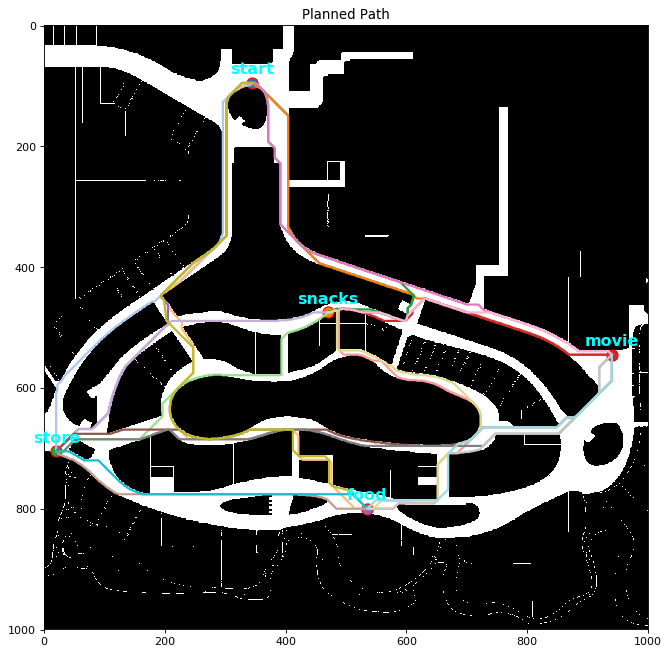

In [58]:
def manhattan_heuristic(p1, p2):
    # p1 and p2 are tuples in (row, col) format.
    # Multiply by cost values so that the heuristic matches the actual travel cost.
    return 0.2 * (abs(p1[0] - p2[0]) + abs(p1[1] - p2[1]))

# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the A* planner.
planner = AStarPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, heuristic_func=manhattan_heuristic)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")


# Visualize all planned paths.
visPath(locations, paths)

Search from both ends

Path found between start and snacks.
Path found between start and store.
Path found between start and movie.
Path found between start and food.
Path found between snacks and start.
Path found between snacks and store.
Path found between snacks and movie.
Path found between snacks and food.
Path found between store and start.
Path found between store and snacks.
Path found between store and movie.
Path found between store and food.
Path found between movie and start.
Path found between movie and snacks.
Path found between movie and store.
Path found between movie and food.
Path found between food and start.
Path found between food and snacks.
Path found between food and store.
Path found between food and movie.
Distance list: [[0, 142.49, 155.13, 178.89, 227.77], [142.49, 0, 114.79, 107.51, 133.43], [155.13, 114.79, 0, 209.42, 110.87], [178.89, 107.51, 209.42, 0, 114.07], [227.77, 133.43, 110.87, 114.07, 0]]
Average time consumed: 0.22 seconds
Total length of path: 2988.74 meters
Averag

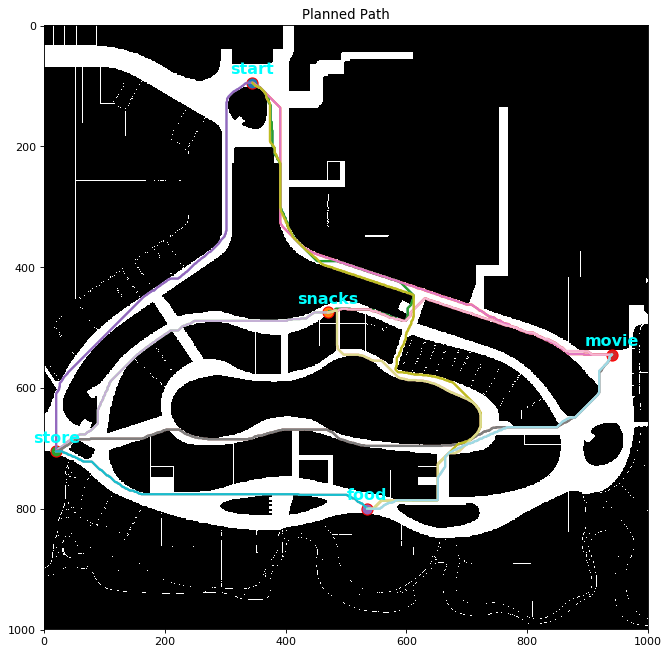

In [59]:
def octile_heuristic(p1, p2):
    # p1 and p2 are tuples in (row, col) format.
    # For 8-connected grids:
    # D is the cost for cardinal moves (here, 0.2), and D2 is for diagonal moves (0.282).
    dx = abs(p1[0] - p2[0])
    dy = abs(p1[1] - p2[1])
    D = 0.2
    D2 = 0.282
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)

# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the BidirectionalAStarPlanner.
planner = BidirectionalAStarPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, heuristic_func=octile_heuristic)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")

# Visualize all planned paths.
visPath(locations, paths)

Greedy Best First Search Algorithm

Path found between start and snacks.
Path found between start and store.
Path found between start and movie.
Path found between start and food.
Path found between snacks and start.
Path found between snacks and store.
Path found between snacks and movie.
Path found between snacks and food.
Path found between store and start.
Path found between store and snacks.
Path found between store and movie.
Path found between store and food.
Path found between movie and start.
Path found between movie and snacks.
Path found between movie and store.
Path found between movie and food.
Path found between food and start.
Path found between food and snacks.
Path found between food and store.
Path found between food and movie.
Distance list: [[0, 151.75, 164.5, 213.67, 238.79], [161.63, 0, 123.53, 142.99, 169.47], [172.1, 120.32, 0, 255.62, 118.71], [195.94, 109.11, 240.0, 0, 206.87], [249.99, 189.01, 132.48, 120.85, 0]]
Average time consumed: 0.03 seconds
Total length of path: 3477.33 meters
Average l

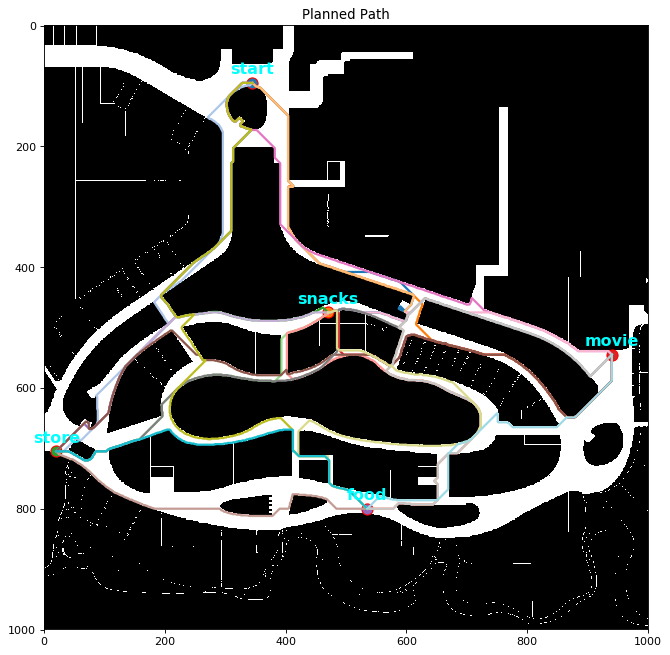

In [60]:
# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the GreedyBestFirstPlanner.
planner = GreedyBestFirstPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, heuristic_func=octile_heuristic)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")

# Visualize all planned paths.
visPath(locations, paths)

Distance list: [[0, '-', '-', '-', '-'], ['-', 0, '-', '-', '-'], ['-', '-', 0, '-', '-'], ['-', '-', '-', 0, '-'], ['-', '-', 141.31, '-', 0]]
Average time consumed: 0.03 seconds
Total length of path: 141.31 meters
Average length of path: 141.31 meters
Success rate: 5.0%


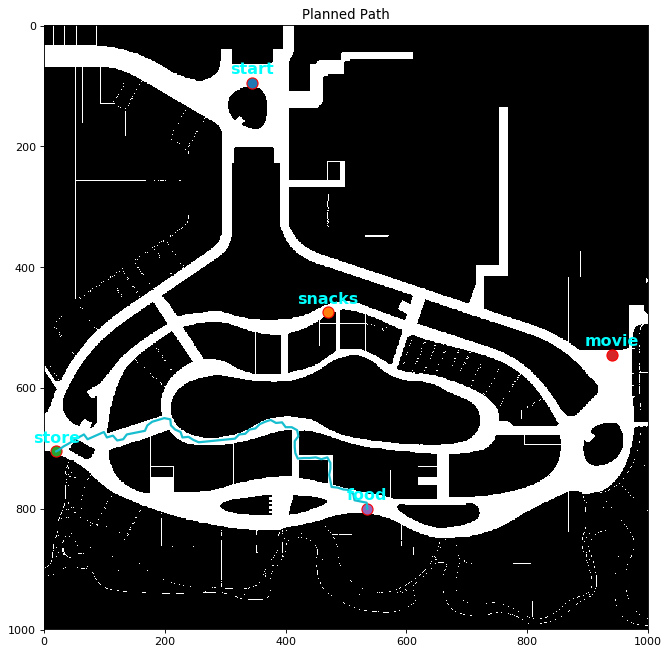

In [61]:
# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the dijkstra planner.
planner = RRTPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, max_iter=1000, step_size=10)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")

# Visualize all planned paths.
visPath(locations, paths)

Dijkstra’s Algorithm

Path found between start and snacks.
Path found between start and store.
Path found between start and movie.
Path found between start and food.
Path found between snacks and start.
Path found between snacks and store.
Path found between snacks and movie.
Path found between snacks and food.
Path found between store and start.
Path found between store and snacks.
Path found between store and movie.
Path found between store and food.
Path found between movie and start.
Path found between movie and snacks.
Path found between movie and store.
Path found between movie and food.
Path found between food and start.
Path found between food and snacks.
Path found between food and store.
Path found between food and movie.
Distance list: [[0, 142.49, 155.13, 178.89, 223.32], [142.49, 0, 114.79, 107.51, 133.43], [155.13, 114.79, 0, 209.42, 110.87], [178.89, 107.51, 209.42, 0, 113.72], [223.32, 133.43, 110.87, 113.72, 0]]
Average time consumed: 0.62 seconds
Total length of path: 2979.14 meters
Averag

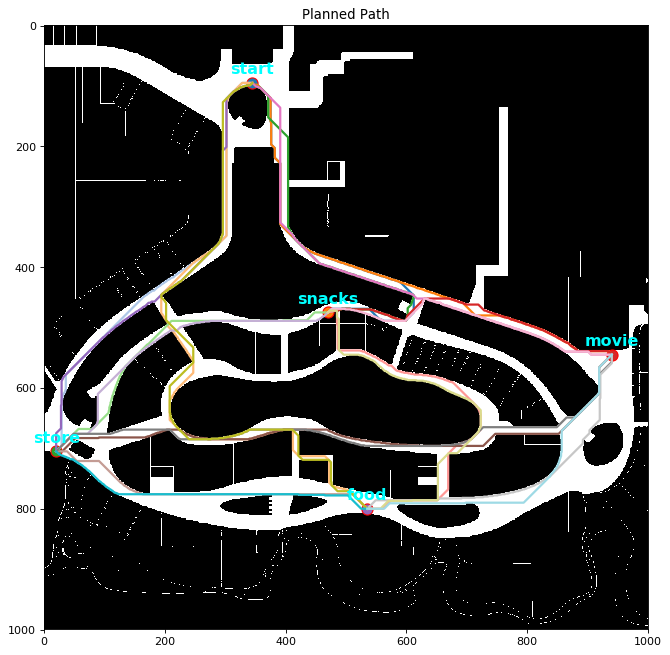

In [62]:
def dijkstra_heuristic(p1, p2):
    return 0

# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the dijkstra planner.
planner = AStarPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, heuristic_func=dijkstra_heuristic)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")

# Visualize all planned paths.
visPath(locations, paths)

Different heuristic functions

Path found between start and snacks.
Path found between start and store.
Path found between start and movie.
Path found between start and food.
Path found between snacks and start.
Path found between snacks and store.
Path found between snacks and movie.
Path found between snacks and food.
Path found between store and start.
Path found between store and snacks.
Path found between store and movie.
Path found between store and food.
Path found between movie and start.
Path found between movie and snacks.
Path found between movie and store.
Path found between movie and food.
Path found between food and start.
Path found between food and snacks.
Path found between food and store.
Path found between food and movie.
Distance list: [[0, 142.49, 155.13, 178.89, 223.32], [142.49, 0, 114.79, 107.51, 133.43], [155.13, 114.79, 0, 209.42, 110.87], [178.89, 107.51, 209.42, 0, 113.72], [223.32, 133.43, 110.87, 113.72, 0]]
Average time consumed: 0.2 seconds
Total length of path: 2979.14 meters
Average

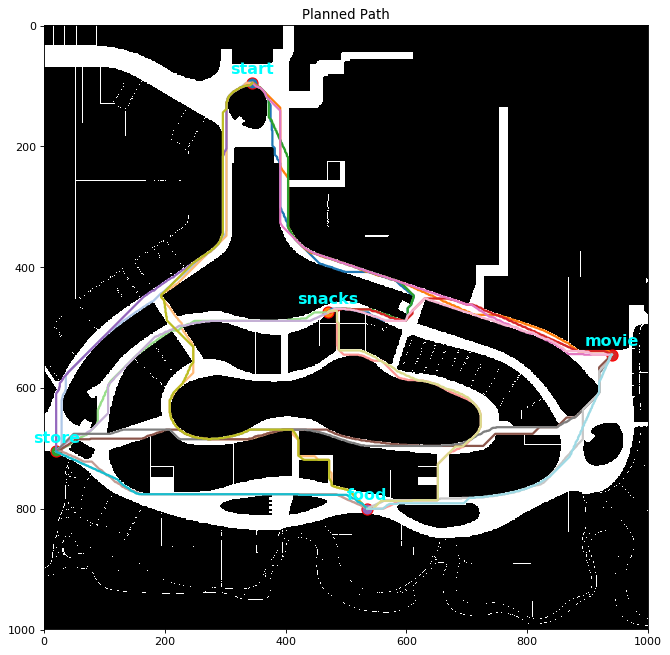

In [63]:
# Create a list of points from the locations dictionary (convert each value to a tuple).
points = [tuple(value) for value in locations.values()]

# Initialize the A* planner.
planner = AStarPlanner(grid_map, resolution=MAP_RES, footprint_radius=0.3, heuristic_func=octile_heuristic)

# Plan paths between all pairs of points and record performance metrics.
paths, distances_total, visited_cells, avg_time, total_length, avg_distance, success_rate = plan_all_paths(points, planner)

# Print performance results.
print(f"Distance list: {distances_total}")
print(f"Average time consumed: {round(avg_time, 2)} seconds")
print(f"Total length of path: {round(total_length, 2)} meters")
print(f"Average length of path: {round(avg_distance, 2)} meters")
print(f"Success rate: {100 * round(success_rate, 2)}%")

# Visualize all planned paths.
visPath(locations, paths)

## Task 2

In [64]:
def tsp_bruteforce(distance_table, paths, points):
    """Solves the TSP using brute-force enumeration.

    Args:
        distance_table (list): A 2D list where distance_table[i][j] gives the travel
            cost from points[i] to points[j].
        paths (list): A list of tuples (start_point, goal_point, path), where both
            start_point and goal_point are tuples (row, col) and path is a list of tuples
            [(row, col)] representing the sub-path from start_point to goal_point.
        points (list): A list of coordinates, each as a tuple (row, col).

    Returns:
        tuple: A tuple (best_route, complete_path) where best_route is a list of indices
            representing the optimal tour (starting and ending at index 0), and complete_path
            is a list of coordinates representing the full path.
    """
    n = len(points)
    # Automatically generate nodes as indices
    nodes = list(range(n))
    start = nodes[0]
    best_cost = float('inf')
    best_route = None

    # Iterate over all permutations of the nodes excluding the starting node.
    for perm in itertools.permutations(nodes[1:]):
        route = [start] + list(perm) + [start]
        cost = 0
        valid_route = True

        # Compute the total cost for this route.
        for i in range(len(route) - 1):
            idx_current = route[i]
            idx_next = route[i + 1]
            segment_cost = distance_table[idx_current][idx_next]
            if segment_cost == float('inf'):
                valid_route = False
                break
            cost += segment_cost

        if valid_route and cost < best_cost:
            best_cost = cost
            best_route = route

    # Build the complete path by concatenating sub-paths.
    complete_path = []
    for i in range(len(best_route) - 1):
        start_idx = best_route[i]
        end_idx = best_route[i + 1]
        start_point = tuple(points[start_idx])
        end_point = tuple(points[end_idx])

        found = False
        for s, e, path in paths:
            if tuple(s) == start_point and tuple(e) == end_point:
                if path is None:
                    raise ValueError(f"No path found between {start_point} and {end_point}")
                if complete_path and complete_path[-1] == path[0]:
                    complete_path.extend(path[1:])
                else:
                    complete_path.extend(path)
                found = True
                break
        if not found:
            print(f"Warning: No path segment found from {start_point} to {end_point}.")

    return best_route, complete_path, best_cost

def tsp_held_karp(distance_table, paths, points):
    """Solves the TSP using the Held-Karp algorithm.

    Args:
        distance_table (list): A 2D list where distance_table[i][j] gives the travel cost from points[i]
            to points[j].
        paths (list): A list of tuples (start_point, goal_point, path). Both start_point and goal_point
            are coordinates (row, col), and path is a list of coordinates [(row, col)] representing
            the sub-path from start_point to goal_point.
        points (list): A list of points, each as a tuple (row, col).

    Returns:
        tuple: A tuple (best_route, complete_path) where best_route is a list of indices representing
            the optimal tour, and complete_path is a list of coordinates representing the full path.
    """
    n = len(points)
    # Automatically generate node indices: [0, 1, 2, ..., n-1]
    nodes = list(range(n))
    dp = {}
    parent = {}

    # Initialize dp for subsets containing only the start (node 0) and one other node.
    for i in range(1, n):
        mask = (1 << 0) | (1 << i)
        dp[(mask, i)] = distance_table[0][i]
        parent[(mask, i)] = 0

    # Dynamic programming: iterate over subsets of increasing size.
    for r in range(3, n + 1):
        for mask in [m for m in range(1 << n) if bin(m).count("1") == r and (m & 1)]:
            for j in range(1, n):
                if not (mask & (1 << j)):
                    continue
                prev_mask = mask ^ (1 << j)
                best_cost = float('inf')
                best_k = None
                for k in range(1, n):
                    if k == j or not (prev_mask & (1 << k)):
                        continue
                    cost = dp.get((prev_mask, k), float('inf')) + distance_table[k][j]
                    if cost < best_cost:
                        best_cost = cost
                        best_k = k
                dp[(mask, j)] = best_cost
                parent[(mask, j)] = best_k

    # Close the tour by returning to the starting node.
    final_mask = (1 << n) - 1
    best_cost = float('inf')
    last_node = None
    for j in range(1, n):
        cost = dp.get((final_mask, j), float('inf')) + distance_table[j][0]
        if cost < best_cost:
            best_cost = cost
            last_node = j

    # Reconstruct the best route as a list of indices.
    mask = final_mask
    curr = last_node
    route_rev = [curr]
    for _ in range(n - 2):
        prev = parent[(mask, curr)]
        route_rev.append(prev)
        mask ^= (1 << curr)
        curr = prev
    route_rev.reverse()
    best_route = [0] + route_rev + [0]

    # Build the complete path by concatenating the sub-paths.
    complete_path = []
    for i in range(len(best_route) - 1):
        start_idx = best_route[i]
        end_idx = best_route[i + 1]
        start_point = tuple(points[start_idx])
        end_point = tuple(points[end_idx])
        found = False
        for s, e, path in paths:
            if tuple(s) == start_point and tuple(e) == end_point:
                if path is None:
                    raise ValueError(f"No path found between {start_point} and {end_point}")
                if complete_path and complete_path[-1] == path[0]:
                    complete_path.extend(path[1:])
                else:
                    complete_path.extend(path)
                found = True
                break
        if not found:
            print(f"Warning: No path segment found from {start_point} to {end_point}.")
    
    return best_route, complete_path, best_cost

Optimal route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total length: 629.72


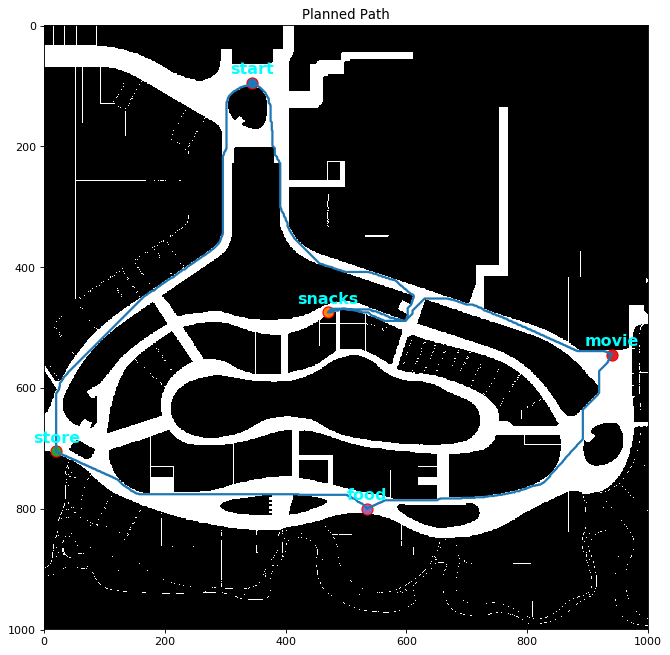

In [65]:
# Compute the optimal route and complete path using the Bruteforcealgorithm.
optimal_route, optimal_path, optimal_cost= tsp_bruteforce(distances_total, paths, points)

# Since optimal_route is a list of indices, use it directly to get coordinates.
start_coord = points[optimal_route[0]]
end_coord = points[optimal_route[-1]]

# Visualize the complete path.
optimal_route_names = [coord_to_name[tuple(points[i])] for i in optimal_route]
print(f"Optimal route: {optimal_route_names}")
print(f"Total length: {(optimal_cost)}")
visPath(locations, [(start_coord, end_coord, optimal_path)])

Optimal route: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total length: 629.72


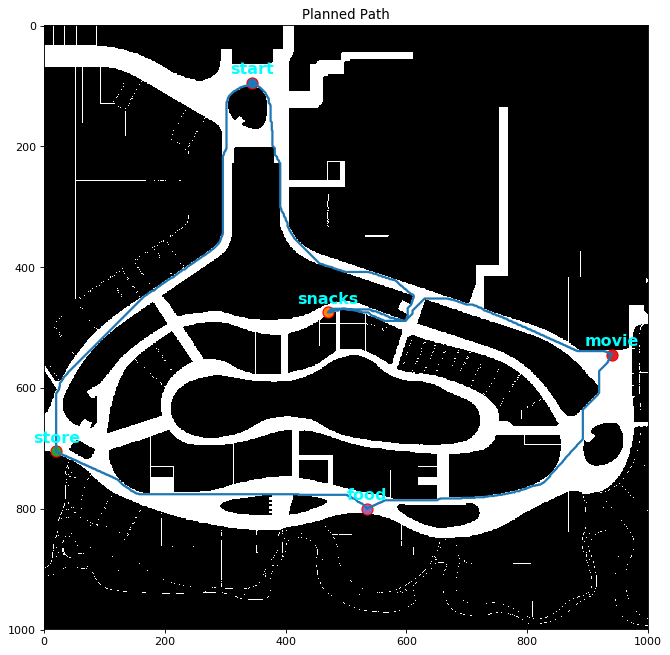

In [66]:
# Compute the optimal route, complete path and best cost using the TSP Held-Karp algorithm.
optimal_route, optimal_path, optimal_cost= tsp_bruteforce(distances_total, paths, points)

# Since optimal_route is a list of indices, use it directly to get coordinates.
start_coord = points[optimal_route[0]]
end_coord = points[optimal_route[-1]]

# Visualize the complete path.
optimal_route_names = [coord_to_name[tuple(points[i])] for i in optimal_route]
print(f"Optimal route: {optimal_route_names}")
print(f"Total length: {(optimal_cost)}")
visPath(locations, [(start_coord, end_coord, optimal_path)])

## Task 3